# Loading required Libraries

In [16]:
import os
import numpy as num
import matplotlib.pyplot as mp
import seaborn as sea
import pandas as pan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import random

 # Setting the Paths

In [5]:
data_corn = '/content/drive/MyDrive/data'

#  Data Preparation & Augmentation

In [6]:
# Defining the image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Developing data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    data_corn,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    data_corn,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# Class mapping
print("Class Indices:", train_generator.class_indices)

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.
Class Indices: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


# Model Design (CNN Architecture)

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,596 (84.86 MB)

 Trainable params: 22,246,148 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

# Performing Model Training

In [8]:
# Early stopping and checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7009 - loss: 10.2747

105/105 ━━━━━━━━━━━━━━━━━━━━ 983s 9s/step - accuracy: 0.7013 - loss: 10.2388 - val_accuracy: 0.2775 - val_loss: 41.0344
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7906 - loss: 0.8916

105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 629ms/step - accuracy: 0.7906 - loss: 0.8912 - val_accuracy: 0.4868 - val_loss: 11.2778
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 625ms/step - accuracy: 0.7998 - loss: 0.6279 - val_accuracy: 0.3349 - val_loss: 11.3943
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7601 - loss: 0.8595

105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 628ms/step - accuracy: 0.7603 - loss: 0.8594 - val_accuracy: 0.6304 - val_loss: 5.2033
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7835 - loss: 0.6433

105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 636ms/step - accuracy: 0.7836 - loss: 0.6433 - val_accuracy: 0.8278 - val_loss: 0.3828
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 622ms/step - accuracy: 0.8101 - loss: 0.4745 - val_accuracy: 0.8325 - val_loss: 0.4520
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 619ms/step - accuracy: 0.8018 - loss: 0.4521 - val_accuracy: 0.8385 - val_loss: 0.4117
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 622ms/step - accuracy: 0.8146 - loss: 0.5647 - val_accuracy: 0.8289 - val_loss: 0.5916
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 73s 695ms/step - accuracy: 0.8007 - loss: 0.5257 - val_accuracy: 0.8062 - val_loss: 0.8266
Epoch 10/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8398 - loss: 0.4136

105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 630ms/step - accuracy: 0.8397 - loss: 0.4141 - val_accuracy: 0.8577 - val_loss: 0.3764


# Evaluation & Visualization (Accuracy & Loss Curves)

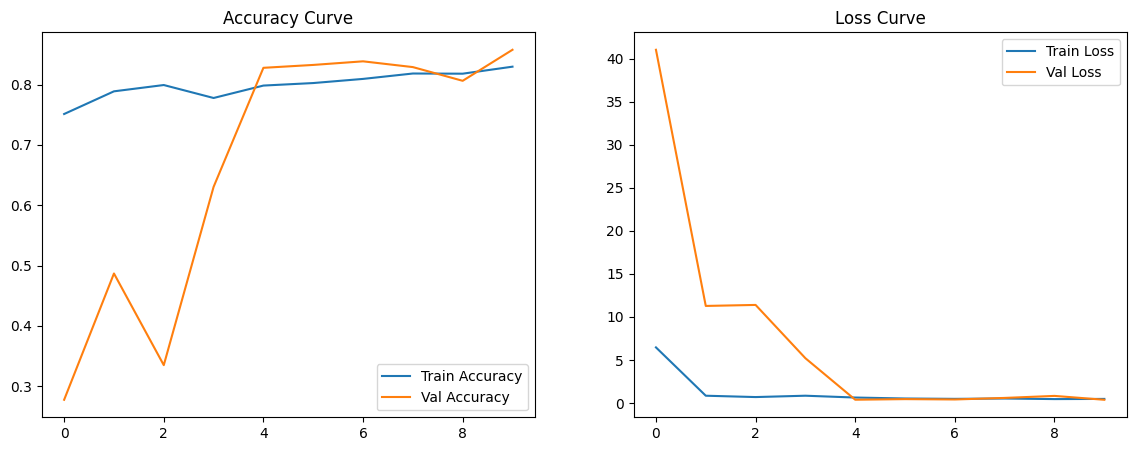

In [9]:
mp.figure(figsize=(14,5))
# Accuracy
mp.subplot(1,2,1)
mp.plot(history.history['accuracy'], label='Train Accuracy')
mp.plot(history.history['val_accuracy'], label='Val Accuracy')
mp.title('Accuracy Curve')
mp.legend()
# Loss
mp.subplot(1,2,2)
mp.plot(history.history['loss'], label='Train Loss')
mp.plot(history.history['val_loss'], label='Val Loss')
mp.title('Loss Curve')
mp.legend()
mp.show()

# Showing Classification Report & Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step
                precision    recall  f1-score   support

        Blight       0.73      0.82      0.78       229
   Common_Rust       1.00      0.93      0.96       261
Gray_Leaf_Spot       0.60      0.56      0.58       114
       Healthy       0.99      0.99      0.99       232

      accuracy                           0.87       836
     macro avg       0.83      0.83      0.83       836
  weighted avg       0.87      0.87      0.87       836



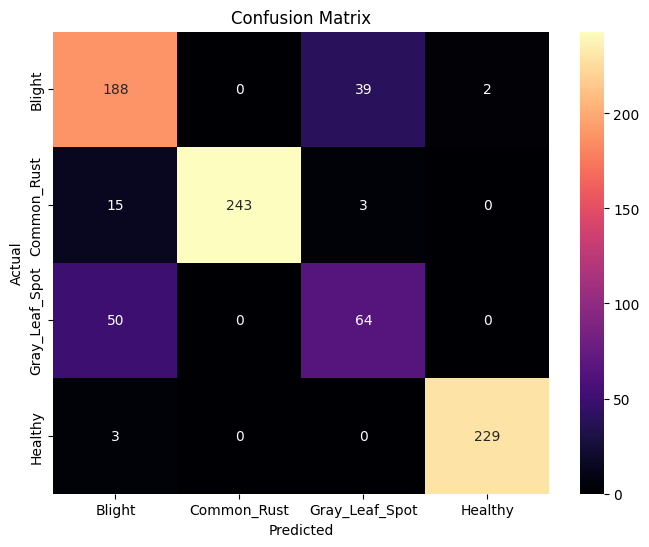

In [12]:
# Prediction on the validation data
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = num.argmax(preds, axis=1)
y_true = val_generator.classes
# Showing Classification Report
target_names = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
mp.figure(figsize=(8,6))
sea.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=target_names, yticklabels=target_names)
mp.title("Confusion Matrix")
mp.xlabel("Predicted")
mp.ylabel("Actual")
mp.show()

# Obtaining Predictions and Map Labels

In [13]:
# Reseting generator and obtain class labels
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
y_pred = num.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
# Show mapping
print("Class Labels:", class_labels)

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step
Class Labels: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


# Demonstrating Display Actual vs Predicted Images

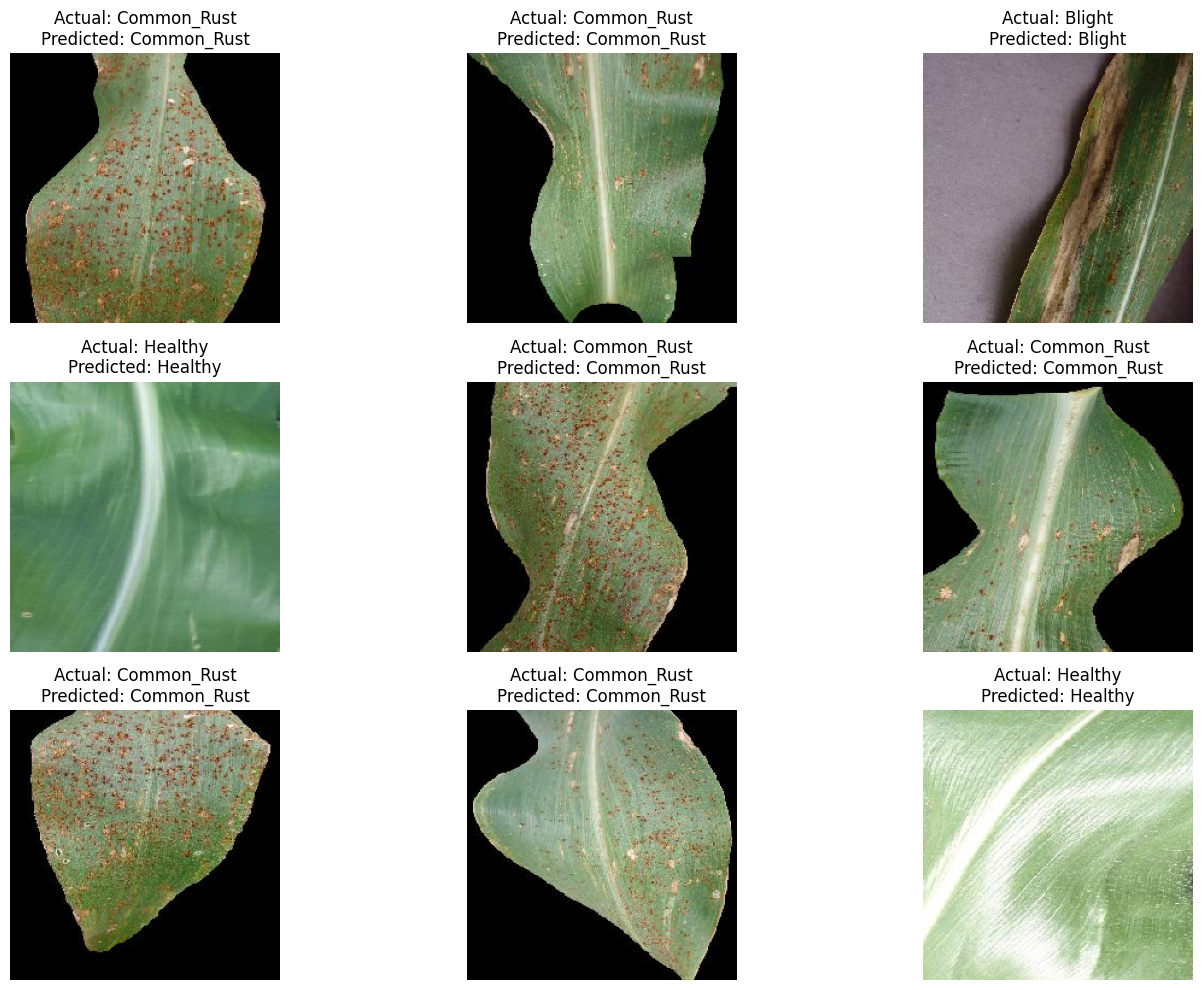

In [14]:
# Obtaining filenames
filenames = val_generator.filenames
image_batch, label_batch = next(val_generator)
num_images = 9
random_indices = random.sample(range(len(y_pred)), num_images)
mp.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    img_path = os.path.join(data_corn, filenames[idx])
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    mp.subplot(3, 3, i + 1)
    mp.imshow(img)
    mp.axis('off')
    mp.title(f"Actual: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred[idx]]}")
mp.tight_layout()
mp.show()

# Showing Prediction Confidence

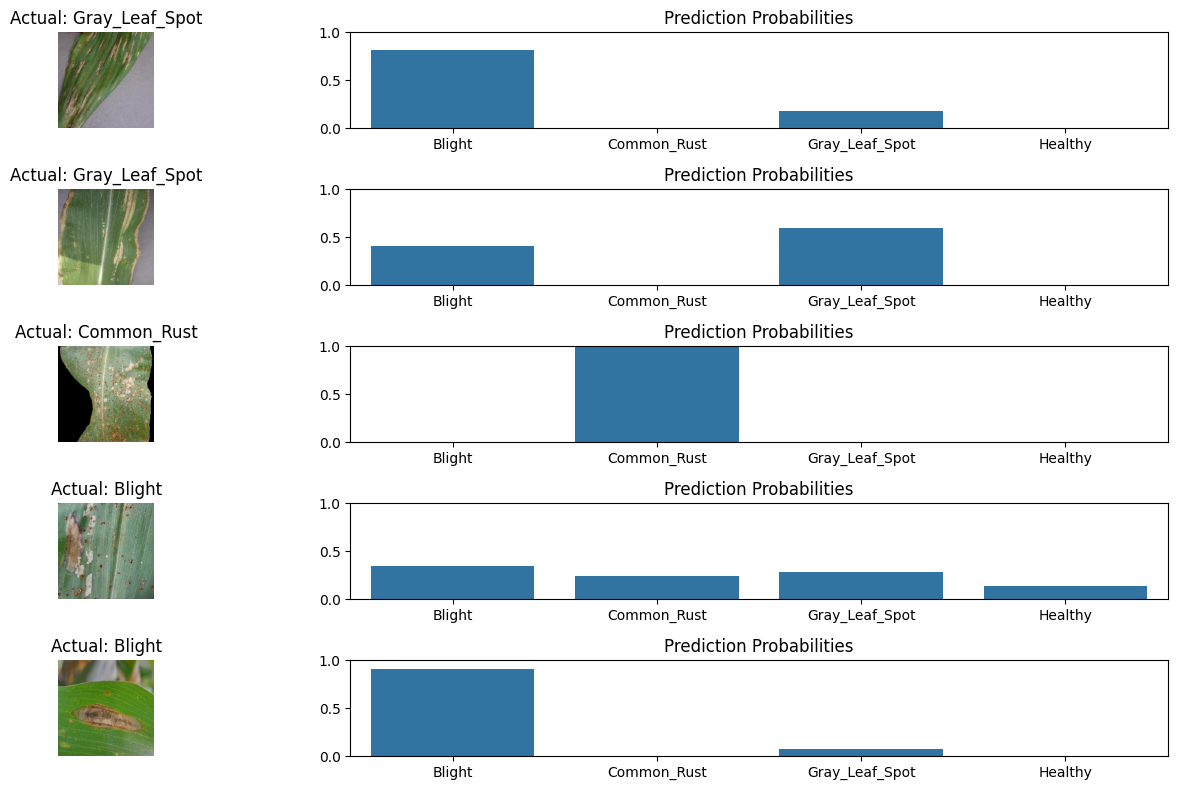

In [18]:
# Plotting top-5 prediction confidence values for random images
num_samples = 5
sample_indices = random.sample(range(len(pred_probs)), num_samples)
mp.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    img_path = os.path.join(data_corn, filenames[idx])
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    mp.subplot(num_samples, 2, 2*i+1)
    mp.imshow(img)
    mp.axis('off')
    mp.title(f"Actual: {class_labels[y_true[idx]]}")

    mp.subplot(num_samples, 2, 2*i+2)
    sea.barplot(x=class_labels, y=pred_probs[idx])
    mp.title(f"Prediction Probabilities")
    mp.ylim(0, 1)
mp.tight_layout()
mp.show()